# This file is used to train

In [21]:
import torch
import numpy as np
from tqdm import tqdm
import pandas as pd
from sc_model import SC_LSTM as Model

# Device init

In [22]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device.type == 'cuda':
    !nvidia-smi
    print(torch.cuda.get_device_name(0))

else:
    print("No GPU :(")

Sun Jul  9 06:00:23 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.41.03              Driver Version: 530.41.03    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1650 Ti      Off| 00000000:01:00.0  On |                  N/A |
| N/A   45C    P5               10W /  N/A|    845MiB /  4096MiB |     27%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [23]:
device = 'cpu'

## Loading the data

In [24]:
from Data.PreprocessorOfGeneratedData import Preprocessor

preproc = Preprocessor()

data = pd.read_csv('../Data/schedule_gen.csv')
data

,Label Number,Duration,Importance,Start Time,Date
0,0,20,0,10:13,10/07/2023
1,1,80,1,12:13,10/07/2023
2,1,40,2,14:53,10/07/2023
3,3,170,2,17:13,10/07/2023
4,1,30,1,20:53,10/07/2023
...,...,...,...,...,...
5386,2,70,0,15:25,16/09/2025
5387,0,20,0,17:00,16/09/2025
5388,1,80,1,18:45,16/09/2025
5389,0,30,1,21:20,16/09/2025


In [25]:
input_data, type_vector, output_data = preproc.preprocess('../Data/schedule_gen.csv')
input_data

,Label Number_0,Label Number_1,Label Number_2,Label Number_3,Duration,Importance_0,Importance_1,Importance_2,Importance_3,Time_Min,...,Date_Month_sin,Date_Month_cos,Plan_Time_Min,Plan_Time_Min_sin,Plan_Time_Min_cos,Plan_Date_Categorical,Plan_Date_Day_sin,Plan_Date_Day_cos,Plan_Date_Month_sin,Plan_Date_Month_cos
0,0,0,0,0,0.090909,0,0,0,0,0.425694,...,-0.5,-8.660254e-01,0.422917,0.465615,-0.884988,0.523288,0.897805,-0.440394,-0.5,-8.660254e-01
1,0,1,0,0,0.454545,0,1,0,0,0.509028,...,-0.5,-8.660254e-01,0.422917,0.465615,-0.884988,0.523288,0.897805,-0.440394,-0.5,-8.660254e-01
2,0,0,0,0,0.212121,0,0,0,0,0.620139,...,-0.5,-8.660254e-01,0.422917,0.465615,-0.884988,0.523288,0.897805,-0.440394,-0.5,-8.660254e-01
3,0,0,0,0,1.000000,0,0,0,0,0.717361,...,-0.5,-8.660254e-01,0.422917,0.465615,-0.884988,0.523288,0.897805,-0.440394,-0.5,-8.660254e-01
4,0,0,0,0,0.151515,0,0,0,0,0.870139,...,-0.5,-8.660254e-01,0.862500,-0.760406,0.649448,0.523288,0.897805,-0.440394,-0.5,-8.660254e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5386,0,0,0,0,0.393939,0,0,0,0,0.000000,...,0.0,1.000000e+00,0.000000,0.000000,1.000000,0.709589,-0.207912,-0.978148,-1.0,-1.836970e-16
5387,0,0,0,0,0.090909,0,0,0,0,0.000000,...,-1.0,-1.836970e-16,0.000000,0.000000,1.000000,0.709589,-0.207912,-0.978148,-1.0,-1.836970e-16
5388,0,0,0,0,0.454545,0,0,0,0,0.000000,...,0.0,1.000000e+00,0.000000,0.000000,1.000000,0.709589,-0.207912,-0.978148,-1.0,-1.836970e-16
5389,0,0,0,0,0.151515,0,0,0,0,0.888889,...,-1.0,-1.836970e-16,0.884722,-0.662620,0.748956,0.709589,-0.207912,-0.978148,-1.0,-1.836970e-16


In [26]:
# Make the data positive
output_data = np.abs(np.array(output_data, dtype=np.float64))
pd.DataFrame(output_data)

,0,1,2
0,0.425694,0.013889,0.000000
1,0.509028,0.057639,0.002083
2,0.620139,0.027778,0.000000
3,0.717361,0.118056,0.000000
4,0.870139,0.020833,0.000000
...,...,...,...
5386,0.000000,0.048611,0.000000
5387,0.000000,0.013889,0.000000
5388,0.000000,0.055556,0.000000
5389,0.888889,0.030556,0.009722


In [27]:
from sklearn.preprocessing import MinMaxScaler

# Normalize input data
scaler = MinMaxScaler()
input_data = scaler.fit_transform(input_data)

## Creating the dataset

In [28]:
from torch.utils.data import Dataset, DataLoader

class ScheduleDataset(Dataset):
    def __init__(self, input_data, type_vector, output_vector, task_types='all', transform=None):
        if task_types == 'all':
            self.input_data = input_data
            self.type_vector = type_vector
            self.output_vector = output_vector
        elif task_types == 'resched':
            self.input_data = []
            self.type_vector = []
            self.output_vector = []
            for i in range(len(input_data)):
                if type_vector[i] == "resched":
                    self.input_data.append(input_data[i])
                    self.type_vector.append(type_vector[i])
                    self.output_vector.append(output_vector[i])
        elif task_types == 'non-resched':
            self.input_data = []
            self.type_vector = []
            self.output_vector = []
            for i in range(len(input_data)):
                if type_vector[i] == "non-resched":
                    self.input_data.append(input_data[i])
                    self.type_vector.append(type_vector[i])
                    self.output_vector.append(output_vector[i])
        else:
            raise ValueError("task_types must be 'all', 'resched', or 'non-resched'")
        self.transform = transform

    def __len__(self):
        return len(self.input_data)

    def __getitem__(self, idx):
        return self.input_data[idx], self.type_vector[idx], self.output_vector[idx]

In [29]:
resched_dataset = ScheduleDataset(input_data, type_vector, output_data, task_types='resched')
non_resched_dataset = ScheduleDataset(input_data, type_vector, output_data, task_types='non-resched')
all_dataset = ScheduleDataset(input_data, type_vector, output_data, task_types='all')

print(f"Resched dataset size: {len(resched_dataset)}\n"
      f"Non-resched dataset size: {len(non_resched_dataset)}\n"
      f"All dataset size: {len(all_dataset)}")

Resched dataset size: 4330
Non-resched dataset size: 1061
All dataset size: 5391


## Create dataloaders

In [30]:
batch_size = 1
# resched_dataset_size = len(resched_dataset)
# train_size = int(resched_dataset_size * 0.8)
# test_size = resched_dataset_size - train_size
#
# train_resched_dataset, test_resched_dataset = torch.utils.data.random_split(resched_dataset, [train_size, test_size])

train_resched_dataloader = DataLoader(resched_dataset, batch_size=batch_size)
# valid_resched_dataloader = DataLoader2(resched_dataset, batch_size=batch_size)

train_non_resched_dataloader = DataLoader(non_resched_dataset, batch_size=batch_size)

## Create free time slots generator

In [31]:
from Data.GeneratorOfAvailableTimeslots import GeneratorOfAvailableTimeslots

time_slots_gen = GeneratorOfAvailableTimeslots(5)
time_slots = time_slots_gen.generate_available_timeslots()

time_slots      # TODO: why all the intervals are closed?
single_interval = time_slots[0]
single_interval


array([[0.01015516, 0.05371325],
       [0.51721207, 0.65374482],
       [0.91265338, 0.91906076],
       [0.93853838, 0.9401393 ]])

## Init the model

In [32]:
# check if the dataloader works and get the input and output sizes
in_features = None
out_features = None
for i, (features, a, ans) in enumerate(train_resched_dataloader):
    in_features = features.shape[1]             # 25
    out_features = ans.shape[1]                 # 3
    break

n_layers = 1
hidden_size = 124
hidden_injector = 64

# Create the model
SC_LSTM = Model(in_features, n_layers, hidden_size, out_features, batch_size, hidden_injector=hidden_injector).to(device)

# Training the model

In [33]:
# Configure hyper-parameters
epochs = 10
learning_rate = 0.001
loss_func = torch.nn.MSELoss()
optimizer = torch.optim.Adam(SC_LSTM.parameters(), lr=learning_rate)

history = []
loss_accomulator = []
mean_loss = None

In [34]:
# Firstly train the LSTM using only reschedulable tasks
SC_LSTM.train_model(mode='lstm')

for epoch in range(0, epochs):
    SC_LSTM.reset_states()
    for i, (X, task_type, Y) in enumerate(tqdm(train_resched_dataloader, desc=f"Epoch: {epoch + 1}, Mean Loss: {mean_loss}", leave=False, colour='green')):

        # Convert X and Y to the correct type
        X = torch.Tensor(X).type(torch.float32).to(device)
        Y = torch.Tensor(Y).type(torch.float32).to(device)

        # Make prediction
        Y_pred = SC_LSTM.forward(X, task_type=task_type, free_time_slots=single_interval, save_states=True)

        # Calculate loss
        loss = loss_func(Y_pred.view(-1, ), Y.view(-1, ))

        # Backward pass
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # Append loss to list
        loss_accomulator.append(loss.item())

    mean_loss = np.mean(loss_accomulator)
    history.append(mean_loss)
    loss_accomulator = []

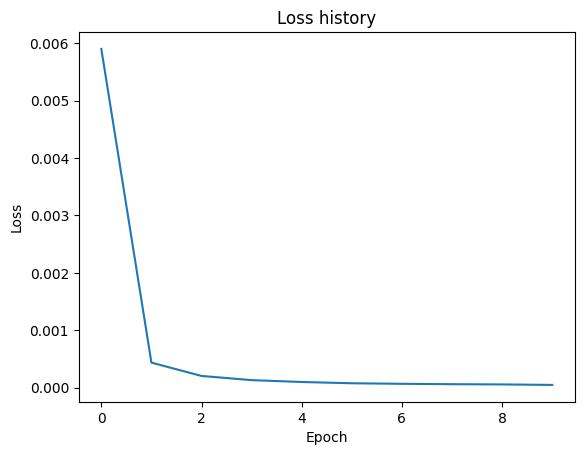

In [35]:
import matplotlib.pyplot as plt
# Plot the loss history
plt.plot(history)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss history")
plt.show()

In [36]:
# Configure hyper-parameters
epochs = 20
learning_rate = 0.001
loss_func = torch.nn.MSELoss()
optimizer = torch.optim.Adam(SC_LSTM.parameters(), lr=learning_rate)

history = []
loss_accomulator = []

In [37]:
# Now train the injector using non-reschedulable tasks
SC_LSTM.train_model(mode='injector')

for epoch in range(0, epochs):
    SC_LSTM.reset_states()

    for i, (X, task_type, Y) in enumerate(tqdm(train_non_resched_dataloader, desc=f"Epoch: {epoch + 1}, Mean Loss: {mean_loss}", leave=False, colour='green')):

        # Convert X and Y to the correct type
        X = torch.Tensor(X).type(torch.float32).to(device)
        Y = torch.Tensor(Y).type(torch.float32).to(device)

        # Make prediction
        Y_pred = SC_LSTM.forward(X, task_type=task_type, free_time_slots=single_interval, save_states=True)

        # Calculate loss
        loss = loss_func(Y_pred.view(-1, ), Y.view(-1, ))

        # Backward pass
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # Append loss to list
        loss_accomulator.append(loss.item())

    mean_loss = np.mean(loss_accomulator)
    history.append(mean_loss)
    loss_accomulator = []

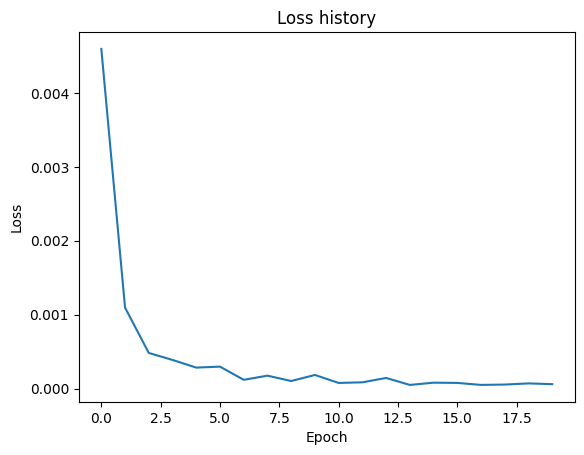

In [38]:
# Plot the loss history
plt.plot(history)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss history")
plt.show()

# Save weights

In [39]:
torch.save(SC_LSTM.state_dict(), "sc_lstm_weights.pth")